# Compression Test Data Analysis
### Logan Halstrom

A visuallization and analysis demonstration of internal combustion engine compression test data. Compare maximum cylinder pressures to reveal performance variations.  Plot cylinder pressure histories.  Compare dry and wet compression tests.

## Background

Why do a compression test

dry vs wet test

## Data Acquisition
Many other guides you can refer to for this
### Instrumentation

Gear rental from Oriley.  A pressure transducer would be much more efficient for this

Camera with equipment for steady recording

Assistant to turn ignition

### Procedure

Things to disconnect

Warnings about guage attachments

How experiment order affects results (I don't know)

### Data Recording

Techniques for gathering pressure time history

Format of spreadsheet

Format of data file

Only maxima analysis is really necessary for functional compression test





## Imports and Plotting Boilerplate
Basic setup and plot formatting

In [90]:
#STANDARD IMPORTS
import numpy as np
import pandas as pd
import os

# #####################################################################
# ### PLOTTING SETUP ##################################################
# #####################################################################

# import matplotlib.pyplot as plt
# %matplotlib inline
# #DEFAULT FIGURE SIZING
# factor = 1 #scaling factor
# plt.rcParams['figure.figsize'] = 6*factor, 6*factor #square plot

# #HOW TO DISABLE AUTOSCROLL OF RESULTS
# from IPython.display import display, Javascript
# disable_autoscroll = """
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#     return false;
# }
# """
# display(Javascript(disable_autoscroll))

# ######################################################################
# #MY CUSTOM PLOTTING SETTINGS (OPTIONAL)

# #CHANGE DEFAULT PLOT COLORS
# #List of hexademical color codes:
# colornames = ["windows blue", "dusty purple", "leaf green",
#                 "macaroni and cheese", "cherry", "greyish", "charcoal",
#                 "salmon pink", "sandstone", "tangerine",]

# #CHANGE DEFAULT FONT SIZES
# Ttl = 32 #Title
# Lbl = 32 #Axis Labels
# Box = 28 #Textbox
# Tck = 22 #Axis tick labels

# #INFO FOR SAVING PLOTS
# savetype = '.png'   #File type of saved plots
# savedir = 'results' #Directory to save plots in
# if not os.path.exists(savedir): #If directory to save plots in doesnt exist,
#     os.makedirs(savedir)        #make directory to save plots in

# #CUSTOM LINE MARKER CYCLES FOR LATER USE
# smallmarkers = ['.', '*', 'd', '1', '+']
# bigmarkers = ['o', 'v', 'd', 's', '*', 'D', 'p', '>', 'H', '8']
# scattermarkers = ['o', 'v', 'd', 's', 'p']

# ########################################################################
# #SET DEFAULT FONT SIZES
# params = {
#           'axes.labelsize' : Lbl,
#           'axes.titlesize' : Ttl,
# #           'text.fontsize'  : Box,
#           'font.size'      : Box,
#           # 'legend.fontsize': Leg,
#           'xtick.labelsize': Tck,
#           'ytick.labelsize': Tck,
#           'font.family': 'helvetica'
# }
# import matplotlib
# matplotlib.rcParams.update(params)

# #SET DEFAULT FIGURE APPERANCE
# import seaborn as sns #Fancy plotting package
# #No Background fill, legend font scale, frame on legend
# sns.set(style='whitegrid', font_scale=1.5, rc={'legend.frameon': True})
# #Mark ticks with border on all four sides (overrides 'whitegrid')
# sns.set_style('ticks')
# #ticks point in
# sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
# #Set new default colormap
# sns.set_palette(sns.xkcd_palette(colornames))
# #FIX INVISIBLE MARKER BUG
# sns.set_context(rc={'lines.markeredgewidth': 0.1})

# colors = sns.color_palette() #Get color cycle for manual colors



#CUSTOM PLOTTING PACKAGE
import matplotlib.pyplot as plt
from lplot import *
from seaborn import color_palette
import seaborn as sns
UseSeaborn('xkcd') #use seaborn plotting features with custom colors
colors = sns.color_palette() #color cycle

## Data Analysis
### Load Data

Choose inputs for your specific test case.  Provide the file path to your test data, give your test a name, and provide plot bounding limits.  Give a percentage threshold for how much a given cylinder can deviate from the maximum of its peers (lower pressure is bad).  Choose whether you would like to analyze only dry compression test data or both dry and wet test data.  Finally, select the approriate number of cylinders for your engine.


In [91]:
#Inputs
path = 'Data/CompTest_2016-02-11_1st_1999Camry.dat'  #Path to datafile
name = 3                    #Name of compression test
ylim = [50, 275]            # Limits for plots
thresh=15                      #percent threshold for poor cylinder performance
tests=['dry', 'wet']           #Types of tests (dry only or wet and try)
ncyl=4                         #Number of cylinders in engine
cyls = np.arange(1, ncyl+1, 1) #List of cylinder numbers

I have formatted my compression test data as comma-separated values, with empty data represented by whitespace.  The data is read into a Pandas dataframe, and the whitespace values are manually replaced with NaN.

I include this extra step so that the data in the spreadsheet can be manually formated into a pseudo-csv format with ease.  You may also choose to save a true .csv file and load it accordingly.

The function for loading my data into a dataframe is contained below:

In [92]:
def ReadCompTestData(filename):
    """Reads compression test data from csv file into pandas dataframe.
    filename --> path to data file to read
    """

    columnnames = ['Stroke', '1dry', '2dry', '3dry', '4dry',
                             '1wet', '2wet', '3wet', '4wet']
    #Read data, assign columnnames
    df = pd.read_csv(filename, sep=',', names=columnnames)
    #Replace whitespace (blanks) with NaNs
    df = df.replace(r'\s+', np.nan, regex=True)
    #Make all value float
    df = df.apply(pd.to_numeric)
    return df

df = ReadCompTestData(path)    #Load compression test pressure data

### Maximum Cylinder Pressure

The first thing we'll do is calculate the maximum pressure attained in each cylinder for each test.  This is a good indicator of how well the cylinder is sealed.  Low values of maximum pressure indicate poor compression performance.  Any cylinder that has a noticably lower pressure than its peers is probably experiencing some uneven form of wear.

After calculating the maximum cylinder pressure, we will also go ahead and normalize each cylinder's pressure history by this value.  This will allow us to compare different cylinders and tests in an "apples-to-apples" manner.

In [93]:
#CALCULATE MAXIMA AND NORMALIZE PRESSURE
maxima = pd.DataFrame( {'cyl' : cyls}) #storage for maxima

for test in tests:
    maxs = []
    for cyl in cyls:
        curkey = '{}{}'.format(cyl, test)
        #Get Local Maximum for Each Cylinder
        maxs.append(max( df[curkey] ))
        #Normalize Current Cylinder by Maximum
        df['{}norm'.format(curkey)] = df[curkey] / maxs[-1]

    maxima['{}max'.format(test)] = maxs #save maxima for current test type

Now that we have some global data about our cylinders, let's compute what is probabably the most important comparison in a compression test: the percent deviation of each cylinder.  

We will only perform this calculation for the dry compression test, as the wet test is only a secondary diagnostic that includes additional variables that could confound our results.

#### Use Greatest Maximum as Baseline

Ideally, we want the maximum pressure of each of the cylinders to be almost identical for any given test.  To make this comparison quantitatively for a given test, we will find the greatest maximum pressure of all of the cylinders and subtract that value from each of the maximum pressures (any pressure lower than this maximum could be considered to have "poorer" performance).  We will then divide by that reference maximum and multiply by 100 to determine the percent difference of each cylinder from the greatest pressure achieved by the engine.

#### Pass or Fail Criteria

To determine whether our cylinders "pass" or "fail" this test, we have set a threshold percentage difference of 15%.  This is not an exact science, so use your own judgement in selecting your threshold value for your specific application.



In [94]:
#CALC FRACTIONAL DIFFERENCE FROM MAX CYLINDER (DRY TEST ONLY)
    #lower pressure is worse.  Calc percent difference of lower
    #max pressures from greatest max pressure.
maxcyl = max(maxima['drymax'])
maxima['diff'] = (maxima['drymax'] - maxcyl) / maxcyl #fractional diff
maxima['percdiff'] = maxima['diff'] * 100 #percent difference

#Print Differences
print('**********************************')
print('Compression Test {}, % difference:'.format(name) )
print( maxima[['cyl', 'percdiff']])
#Determine if any cylinders are outside of success threshold
failures = maxima[maxima['percdiff'] < -thresh]
if not failures.empty:
    print('WARNING: FOLLOWING CYLINDERS ARE ' \
            'BELOW {}% OF MAXIMUM (FAIL)!!!'.format(thresh))
    print( failures[['cyl', 'percdiff']])
else:
    print('ALL MAXIMUM CYLINDER PRESSURES ARE ' \
            'WITHIN THRESHOLD (PASS)!!!')

**********************************
Compression Test 3, % difference:
   cyl  percdiff
0    1  0.000000
1    2 -3.225806
2    3 -0.921659
3    4 -3.225806
ALL MAXIMUM CYLINDER PRESSURES ARE WITHIN THRESHOLD (PASS)!!!


As you can see, our threshold criteria allows the code to determine whether to post a "pass" or "fail" message.  If any cylinders "fail", these will be the first to look at as a cause for any poor performance you have noticed while driving.  However, take the results of this test with a grain of salt, as they only show each cylinder's performance _relative to its peers_.

### Pressure Time Histories

The previous section concerned a global comparison of cylinders among themselves.  Now, we will use our painstakingly gathered data points for a more detailed analysis.  By plotting the pressure of each cylinder after each stroke during the test, we will be able to visualize cylinder performace _throughout_ the test.

If you saw low pressures in the dry test, you may have also collected wet test data.  The following code will plot the pressure history of a dry compression test alone, or coplot the dry test data with the wet test data.

In [95]:
def PlotPressHist(df, ylim=None, norm=False,
                    tests=['dry', 'wet'], cyls=[1, 2, 3, 4] ):
    """For a single compression test, plot cylinder pressure history.
    Plot dry vs wet tests if data is available for both
    df --> pandas dataframe containing test data
    ylim --> boundaries of y-axis ([ymin, ymax])
    norm --> plot normalized values instead (must calculate beforehand)
    """

    ylbl = 'Cylinder Pressure [psi]'
    if norm:
        ylbl = 'Norm. Cyl. Pressure [N.D.]'
    _,ax = PlotStart(None, 'Engine Stroke', ylbl, figsize=[8, 8])

    mhandles = [] #dry/wet
    mlabels = []
    nhandles = [] #cyl number
    nlabels = []

    for i, (test, marker) in enumerate(zip(tests, ['o', '.'])):
        for j, cyl in enumerate(cyls):

            name = '{}{}'.format(cyl, test) #data key name
            if norm:
                #key for data normalized by its maximum
                name = '{}norm'.format(name)

            h, = ax.plot(df['Stroke'].values, df[name].values,
                        label=name, color=colors[j],
                        linestyle='-', marker=marker, markersize=8
                        )
            if j == 0:
                mhandles.append(h)
                mlabels.append(str(test))
            if i == 0:
                nhandles.append(h)
                nlabels.append(str(cyl))
    ax.set_xlim([0, max(df['Stroke'])])
    plt.xticks(np.arange(1, max(df['Stroke'])+1, 2.0))
    if ylim != None:
        ax.set_ylim(ylim)

    #Cylinder Legend
    leg1 = PlotLegendLabels(ax, nhandles, nlabels,
                            loc='lower right', title='Cyl')
    if len(tests) > 1:
        #Test Type Legend
        leg2 = PlotLegendLabels(ax, mhandles, mlabels,
                                loc='lower center', title='Test')
        plt.gca().add_artist(leg1)

    return ax

I performed both a dry and wet compression test for my example, so the results are plotted together below:

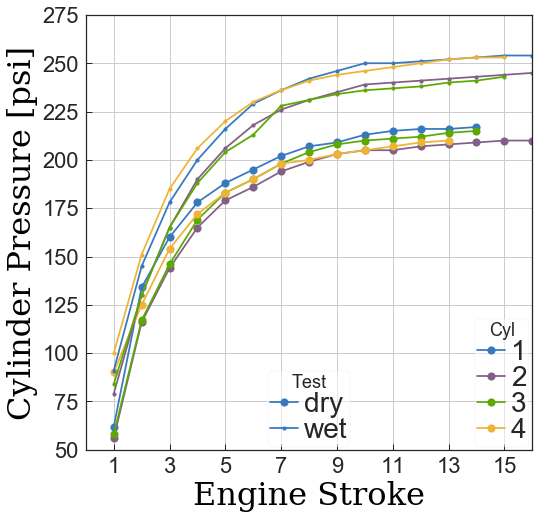

In [96]:
#PLOT COMPRESSION TEST PRESSURE HISTORIES (DRY VS WET IF AVAILABLE)
PlotPressHist(df, ylim, tests=tests, cyls=cyls)
plt.show()

In the above figure, the different cylinders are denoted by line color and the separate dry and wet tests are signified by marker size.

Looking at the shape of the plots, we see that the general behavior of pressure increase is similar for all of the cylinders, with slight variations between different cylinders in the same test, and a marked difference between the two test types. 

The similarity in behavior between all cylinders can be further demonstrated in a plot of the pressure histories normalized by their respective maximum pressures:

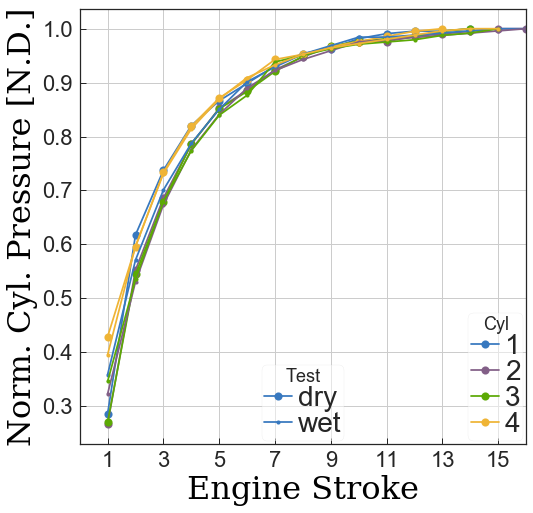

In [97]:
#PLOT NORMALIZED PRESSURE HISTORIES (DRY VS WET IF AVAILABLE)
PlotPressHist(df, None, norm=True, tests=tests, cyls=cyls)
plt.show()

Here we see the normalized pressure histories of _all_ cylinders in _all_ tests fold up into an almost identical curve.  This plot is somewhat trivial diagnostically.  It demonstrates that the behavior among all cylinders is similar.  In the event of a misfunctioning cylinder, however, it could help further demonstrate the nature of this malfunction, after the previous maximum pressure test had already identified this problem cylinder.

### Dry vs Wet Compression Test Comparison

We've already determined from the maximum pressure test that the variation within each test type is within our threshold, but we will need to do some further analysis to quantify the difference between the two test types.

To determine how much the cylinder pressure increases due to the oil sealing the rings in the wet test, we will subtrace the dry test pressure values directly from the wet test values.  We will extend all data sets to be the same size by copying the last value of the test as many times as is needed.  This practice seems sound since the pressure history behavior shows an exponential diminuation of pressure increase as a function of time.

In [98]:
#CALCULATE DIFFERENCE BETWEEN WET AND DRY TESTS
for cyl in cyls:
    for test in tests:
        #FILL MISSING STROKE DATA WITH LAST RECORDED VALUE
        curkey = '{}{}'.format(cyl, test)
        #Get last value (non-NaN)
        lastval = df[curkey].dropna().iloc[-1]
        #Replace NaN values with last value
        df[curkey] = df[curkey].fillna(lastval)

    #SUBTRACT DRY TEST PRESSURE FROM WET TEST PRESSURE
    df['{}del'.format(cyl)] = (df['{}wet'.format(cyl)]
                                 - df['{}dry'.format(cyl)])

The wet-dry delta plotting function contained below is similar to the pressure history plot, with different axis labels and less legends.  Normalization is achieved by dividing each cylinder's value by the maximum dry pressure of that same cylinder.  Thus, we can look the fractional difference of the wet test pressures from those of the dry pressures on a cylinder by cylinder basis.

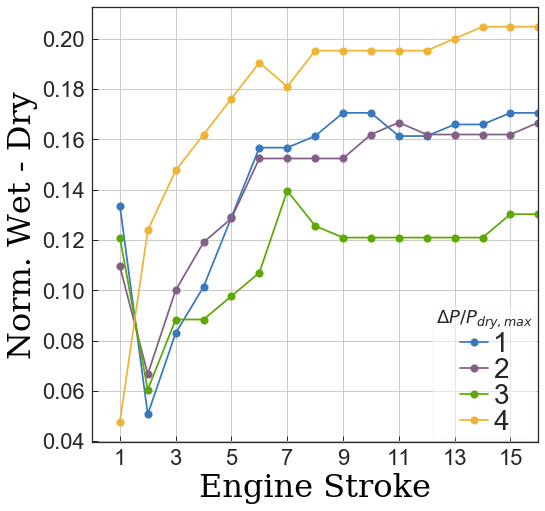

In [99]:
def PlotDryVsWetDelta(df, ylim=None, norm=1):
    """For a single compression test, plot wet - dry delta.
    df --> pandas dataframe containing test data
    ylim --> boundaries of y-axis ([ymin, ymax])
    norm --> normalization factor (1 for none, max dry values otherwise)
    """

    if max(norm) == 1:
        #Non-normalized plot
        norm = np.ones(4)
        ylbl = 'Wet - Dry [psi]'
        legtitle = '$\\Delta P$'
    else:
        #Normalize each delta by max pressure of that cylinder
        ylbl = 'Norm. Wet - Dry'
        legtitle = '$\\Delta P / P_{dry,max}$'

    _,ax = PlotStart(None, 'Engine Stroke', ylbl, figsize=[8, 8])


    for j, cyl in enumerate([1, 2, 3, 4]):

        name = '{}del'.format(cyl) #data key name
        h, = ax.plot(df['Stroke'].values, df[name].values / norm[j],
                    label=cyl, color=colors[j],
                    linestyle='-', marker='o', markersize=8
                    )

    ax.set_xlim([0, max(df['Stroke'])])
    plt.xticks(np.arange(1, max(df['Stroke'])+1, 2.0))
    if ylim != None:
        ax.set_ylim(ylim)

    leg1 = PlotLegend(ax, loc='lower right', title=legtitle)

    return ax

#PLOT DELTAS AS FRACTION OF MAX DRY PRESSURE FOR EACH CYLINDER
ax = PlotDryVsWetDelta(df, None, norm=maxima['drymax'])
plt.show()

The pressure increase from the dry test due to the addition of oil to the cylinder in the wet test as a fraction of the original dry test maxima is plotted above.

For this example, we see significant wet test pressure increases (greater than 15% in some cases).  In general, this indicates that the piston rings are probably worn and leaky, but I have been unable to determine how true this diagnostic actually proves to be.  To me, it seems that pouring oil into a cylinder to seal the rings will increase the cylinder pressure regarless of ring quality.  However, since I have only performed the test on older (>16 year old) cars, I cannot prove that this is the case yet.

The varied pressure behavior during the initial stroke can possibly be dismissed as transient, but could also indicate something about the behavior of the #4 cylinder

### Conclusions

This example demonstrates some simple analyses that can be performed on compression test data to help determine the general health of an internal combustion engine and diagnose malfunctions.

For the example test, it was determined that all four cylinders on the vehicle are performing within tolerance of eachother, but that they all may be suffering from leaky piston rings, as demonstrated by the wet test.

However, since all of the cylinders' maximum pressure are well above the factory specified values for this engine, it is my opinion that the engine is in general working order and may be experiencing piston ring wear expected for >200000 miles of use but is healthly overall.

### Notebook Styling Setup

In [100]:
#NOTE: 'styles' folder must be downloaded and placed in the path shown below
    #Otherwise comment this section out
from IPython.core.display import HTML
def css_styling():
   styles = open('styles/custom.css', 'r').read()
   return HTML(styles)
css_styling()